In [5]:
%matplotlib inline
import sys
import csv
import os
os.environ['PROJ_LIB'] = '/home/gbraun/anaconda3/share/proj'
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse as ss
import scipy.stats as st
import seaborn as sns
from signet.cluster import Cluster
import utils as ut
import matplotlib
#from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score
from scipy.spatial.distance import pdist, squareform
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from functions import *
from mpl_toolkits.basemap import Basemap

In [6]:
# Load data
corr_df=pd.read_csv('data/corr_mat.csv',index_col=0)
stat_lat_lon_df = pd.read_csv('data/stations_coords.csv')
stat_lat_lon_df = stat_lat_lon_df.drop(stat_lat_lon_df.columns[[0]],axis=1)
stat_lat_lon_df.head()

,Station,Latitude,Longitude
0,14825,-16.40,131.01
1,43038,-26.58,149.19
2,63005,-33.43,149.56
3,25015,-35.26,140.91
4,61010,-32.59,151.78


In [7]:
# Create the signed graph 
corr=corr_df.to_numpy()

# Adjacency matrices (positive and negative)
Ap = (corr + abs(corr))/2.
Am = (abs(corr)- corr)/2.
Aps = ss.csc_matrix(Ap)
Ams = ss.csc_matrix(Am)

# Covariates
X = np.array(stat_lat_lon_df,dtype=float)

In [58]:
# Cluster
# Sponge clustering
m = Cluster((Aps, Ams))
k=5
predictions = m.SPONGE(k, tau_p=1, tau_n=1, eigens=None, mi=None)
predictions2 = iter_csbm(Ap-Am,X,convertClust(predictions),k, iter=17)
predictions3 = iter_csbm2(Ap-Am,X,convertClust(predictions),k, iter=17)
predictions4 = iter_sbm(Ap-Am,convertClust(predictions),k,iter=17)

kmeans = KMeans(init="k-means++",n_clusters=k)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)
kmeans.fit(scaled_features)
predictions5 = kmeans.labels_

# Plots

In [59]:
# Sort the adjacency matrices

# Compute the permutation (Sponge)
permut =[]
for i in range(k):
    permut= permut+[j for j in range(306) if predictions[j]==i]
    
# Sort the adjacency matrices
ssortedp = m.p.todense()[permut,:][:,permut]
ssortedn = m.n.todense()[permut,:][:,permut]

# Compute the permutation (sIR-CSBM)
permut2 =[]
for i in range(k):
    permut2= permut2+[j for j in range(306) if predictions2[j]==i]
    
# Sort the adjacency matrices
ssortedp2 = m.p.todense()[permut2,:][:,permut2]
ssortedn2 = m.n.todense()[permut2,:][:,permut2]

# Compute the permutation (IR-CSBM)
permut3 =[]
for i in range(k):
    permut3= permut3+[j for j in range(306) if predictions3[j]==i]
    
# Sort the adjacency matrices
ssortedp3 = m.p.todense()[permut3,:][:,permut3]
ssortedn3 = m.n.todense()[permut3,:][:,permut3]

# Compute the permutation (iter_sbm)
permut4 =[]
for i in range(k):
    permut4= permut4+[j for j in range(306) if predictions4[j]==i]
    
# Sort the adjacency matrices
ssortedp4 = m.p.todense()[permut4,:][:,permut4]
ssortedn4 = m.n.todense()[permut4,:][:,permut4]


# Compute the permutation (k-means on covariates)
permut5 =[]
for i in range(k):
    permut5= permut5+[j for j in range(306) if predictions5[j]==i]
    
# Sort the adjacency matrices
ssortedp5 = m.p.todense()[permut5,:][:,permut5]
ssortedn5 = m.n.todense()[permut5,:][:,permut5]

In [60]:
stations_a = stat_lat_lon_df[["Station"]]
stations_a = stations_a.to_numpy()
stat_lat_lon_a = stat_lat_lon_df.to_numpy()
cmap = matplotlib.cm.get_cmap('tab10')
markers_ = ['o', 'v', '^', '<', '>',  's', 'p', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8']
# input desired coordinates
my_coords = stat_lat_lon_a[0, 1:3]

# How much to zoom from coordinates (in degrees)
zoom_scale = 20

# Setup the bounding box for the zoom and bounds of the map
bbox = [-46, -8, 110, 158]



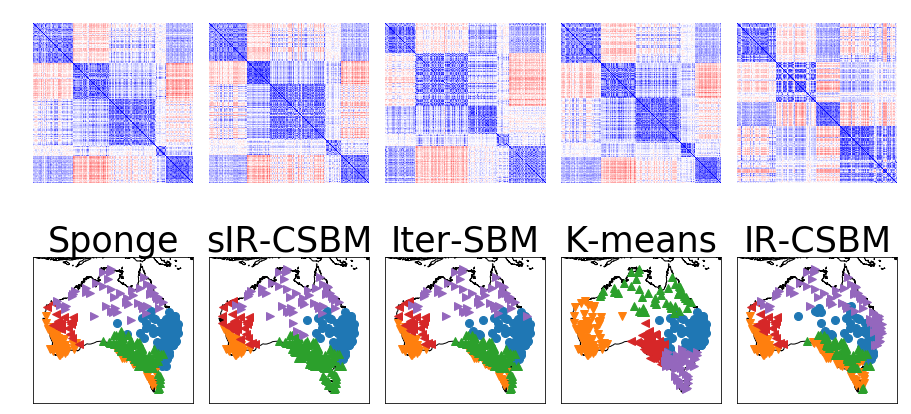

In [61]:
fig, axs = plt.subplots(2, 5)
axs[0, 0].matshow(ssortedp-ssortedn,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 0].axis('off')
axs[0, 1].matshow(ssortedp2-ssortedn2,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 1].axis('off')
axs[0, 2].matshow(ssortedp3-ssortedn3,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 2].axis('off')
axs[0, 3].matshow(ssortedp4-ssortedn4,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 3].axis('off')
axs[0, 4].matshow(ssortedp5-ssortedn5,cmap='bwr_r',vmin=-1,vmax=1)
axs[0, 4].axis('off')

#Second line
axs[1, 0].set_title("Sponge",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,0])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])


axs[1, 1].set_title('sIR-CSBM',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions2==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,1])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])


axs[1, 4].set_title('IR-CSBM',fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions3==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
    
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,4])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    

axs[1, 2].set_title("Iter-SBM",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions4==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,2])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])    
    

axs[1, 3].set_title("K-means",fontsize=35)
grouped_coords = []
for i in range(k):
    i_stations = stations_a[predictions5==i]
    i_coords = []
    for s in i_stations:
        idx = np.where(stat_lat_lon_a[:,0] == s)
        i_coords.append(stat_lat_lon_a[idx])
    grouped_coords.append(i_coords)
mm = Basemap(projection='merc',llcrnrlat=bbox[0],urcrnrlat=bbox[1],\
            llcrnrlon=bbox[2],urcrnrlon=bbox[3],lat_ts=10,resolution='i',ax=axs[1,3])

# Draw coastlines and fill continents and water with color
mm.drawcoastlines()
colors = ['r', 'g', 'b', 'c', 'y']
markers = []
for i in range(k):
    coords = np.array(grouped_coords[i])[:, 0, 1:3]
    x,y = mm(coords[:,1],coords[:,0])
    mm.plot(x,y, color = cmap(i), markersize=8, lw = 0, marker = markers_[i])
    
plt.subplots_adjust(left=0,
                    bottom=0, 
                    right=2, 
                    top=2, 
                    wspace=0.1, 
                    hspace=-0.35)

plt.show()